In [257]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [191]:
data= pd.read_csv("historical_data.csv")

In [192]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [193]:
print(data.shape)
print(data.isna().sum())

(197428, 16)
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [195]:
data['created_at']=pd.to_datetime(data['created_at'])
data['actual_delivery_time']=pd.to_datetime(data['actual_delivery_time'])

In [196]:
#creating the target variable and getting the difference between the actual delivery time and time of order to calculate time difference in seconds

data['total_delivery_duration']=(data['actual_delivery_time']-data['created_at']).dt.total_seconds()
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [197]:
#performing feature engineering to calculate the number of busy dashers ratio
data['busy_dasher_ratio']= data['total_busy_dashers']/data['total_onshift_dashers']

In [198]:
#adding the values of time taken to place order and time taken to drive from store to consumer's address and labelling it 'non prep duration' as it excludes time taken by restaurant to prep order
data['non_prep_duration']=data['estimated_order_place_duration']+data['estimated_store_to_consumer_driving_duration']

In [199]:
#finding number of unique cities/markets and restaurants alongside the mode of order placement
print(data['market_id'].nunique())
print(data['store_id'].nunique())
print(data['order_protocol'].nunique())
#the data consists of restaurants in 6 different cities and with 6743 unique restaurants across these cities in total with their corresponding mode for order placement

6
6743
7


In [200]:
#create dictionary for most common categories and fill NULL values
unique_storeid= data['store_id'].unique().tolist()
storeid_category={store_id: data[data.store_id==store_id].store_primary_category.mode()
                 for store_id in unique_storeid}


In [201]:
#filling NULL values
def fill(store_id):
    try:
        return storeid_category[store_id].values[0]
    except:
        return np.nan
    
    
data["new_store_category"]=data.store_id.apply(fill)

In [202]:
#using dummies function in pandas for one hot encoding
#for order_protocol
order_protocol_dummies= pd.get_dummies(data.order_protocol)
order_protocol_dummies=order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [203]:
#for market_id
market_id_dummies= pd.get_dummies(data.market_id)
market_id_dummies=market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [204]:
#for store category
store_primary_category_dummies= pd.get_dummies(data.store_primary_category)
store_primary_category_dummies=store_primary_category_dummies.add_prefix('store_primary_category_')
store_primary_category_dummies.head()

,store_primary_category_afghan,store_primary_category_african,store_primary_category_alcohol,store_primary_category_alcohol-plus-food,store_primary_category_american,store_primary_category_argentine,store_primary_category_asian,store_primary_category_barbecue,store_primary_category_belgian,store_primary_category_brazilian,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
#drop the columns which have now been one hot encoded(market_id, store_primary_category and order_protocol) alongside other columns which are target variables(created_at and actual_delivery_time)

train_df=data.drop(columns=['created_at','store_id','market_id','store_primary_category','actual_delivery_time','new_store_category','order_protocol'])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dasher_ratio,non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [206]:
train_df=pd.concat([train_df,order_protocol_dummies,market_id_dummies,store_primary_category_dummies],axis=1)

In [207]:
train_df=train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.242188,2.670791,686.189941,1159.415405,44.808094,41.739746,58.050064,309.313446,545.358765,...,0.000790,0.000187,0.005531,0.011077,0.000740,0.036596,0.001200,0.001413,0.004280,0.030872
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028089,0.013687,0.074258,0.104692,0.027177,0.187825,0.034613,0.037549,0.065248,0.173032
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
train_df['busy_dasher_ratio'].describe()
#this column has infinite values as max value due to division by 0 error. correcting it now..
np.where(np.any(~np.isfinite(train_df),axis=0)== True)

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [210]:
#converting infinite values to NULL/NaN values first and then dropping those rows from train data
train_df.replace([np.inf,-np.inf],np.nan, inplace=True)
train_df.dropna(inplace=True)

In [211]:
train_df.shape

(177070, 100)

In [212]:
#building a correlation matrix and visualizing it to understand the most valuable features required for training 
corr=train_df.corr()

<AxesSubplot:>

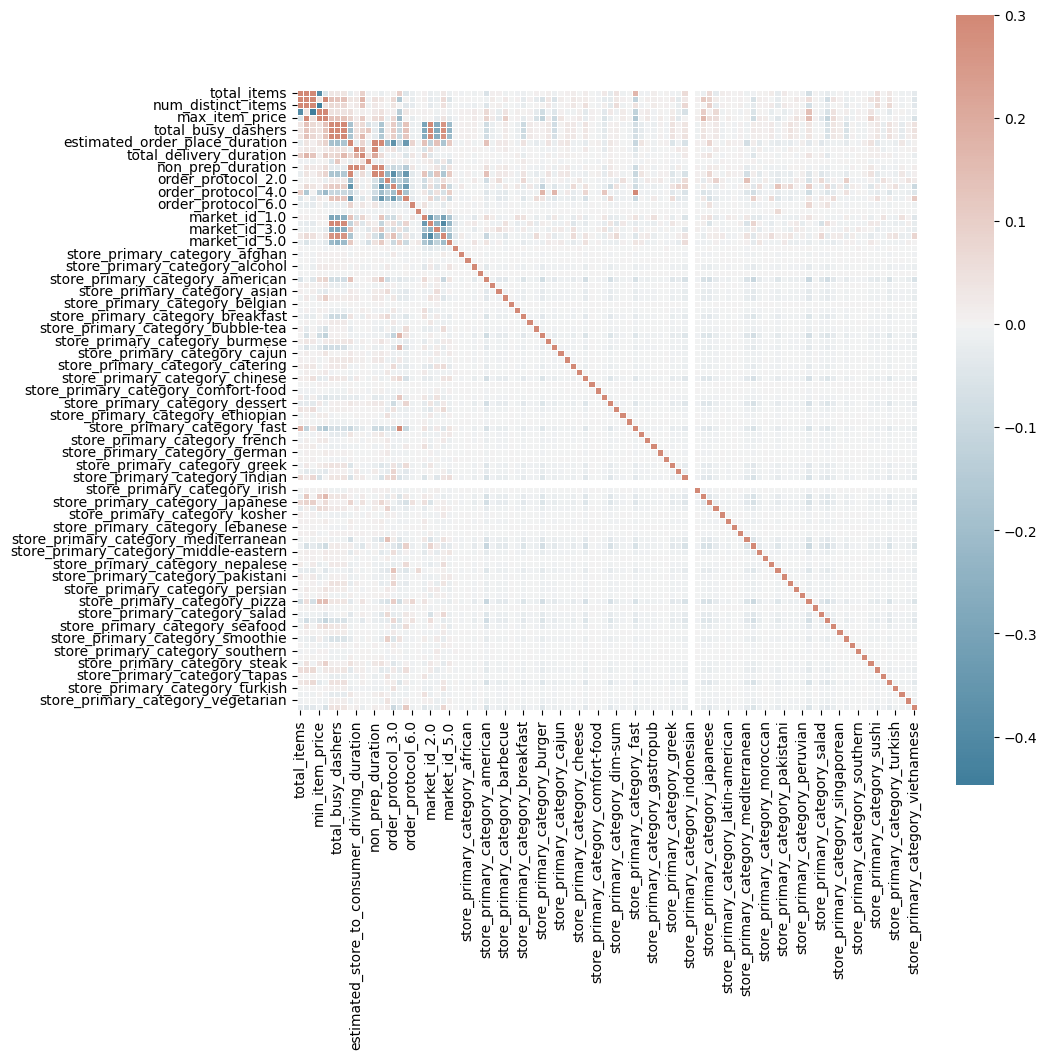

In [213]:
f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5)

In [214]:
#there seems to be an issue with the indonesian category as seen in the correlation matrix

train_df['store_primary_category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: store_primary_category_indonesian, dtype: float64

In [215]:
#drop diagonal values with correlation as 1
def get_redudant_val(df):
    pairs_drop=set()
    cols=df.columns
    for i in range(0,df.shape[1]):
        for j in range(0,i+1):
            pairs_drop.add((cols[i],cols[j]))
    return pairs_drop

In [216]:
#get columns with correlation in desc order with n highest being displayed
def get_top_correlation(df,n=5):
    au_corr=df.corr().abs().unstack()
    labels_to_drop=get_redudant_val(df)
    au_corr=au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
    

In [217]:
print("Top Absolute Correlations")
print(get_top_correlation(train_df,20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  non_prep_duration              0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            store_primary_category_fast    0.495431
num_distinct_items          

In [218]:
#as seen market id are closely related to each other, we drop them . We also drop highly corelated features
train_df=train_df.drop(columns=['market_id_1.0','market_id_2.0','market_id_3.0','market_id_4.0','market_id_5.0','market_id_6.0','non_prep_duration','store_primary_category_indonesian','total_onshift_dashers','total_busy_dashers'],axis=1)


In [219]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dasher_ratio,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
#new correlations 
print("Top Absolute Correlations")
print(get_top_correlation(train_df,20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0             0.897645
total_items                     num_distinct_items             0.758146
subtotal                        num_distinct_items             0.682890
total_items                     subtotal                       0.557175
min_item_price                  max_item_price                 0.541241
subtotal                        max_item_price                 0.507947
order_protocol_4.0              store_primary_category_fast    0.495431
num_distinct_items              min_item_price                 0.446733
total_items                     min_item_price                 0.389277
order_protocol_1.0              order_protocol_3.0             0.373581
estimated_order_place_duration  order_protocol_3.0             0.364170
order_protocol_1.0              order_protocol_5.0             0.342345
estimated_order_place_duration  order_protocol_5.0             0.333291
order_protocol_3.0              order_

In [221]:
#order protocol is also having high correlation amongst its sub categories. we drop those columns too
train_df=train_df.drop(columns=['order_protocol_1.0','order_protocol_2.0','order_protocol_3.0','order_protocol_4.0','order_protocol_5.0','order_protocol_6.0','order_protocol_7.0'],axis=1)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dasher_ratio,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
#new correlations 
print("Top Absolute Correlations")
print(get_top_correlation(train_df,20))

Top Absolute Correlations
total_items                                   num_distinct_items                 0.758146
subtotal                                      num_distinct_items                 0.682890
total_items                                   subtotal                           0.557175
min_item_price                                max_item_price                     0.541241
subtotal                                      max_item_price                     0.507947
num_distinct_items                            min_item_price                     0.446733
total_items                                   min_item_price                     0.389277
estimated_store_to_consumer_driving_duration  total_delivery_duration            0.188418
subtotal                                      total_delivery_duration            0.172312
total_outstanding_orders                      estimated_order_place_duration     0.171049
total_items                                   store_primary_category_fast 

In [223]:
#new features
train_df['avg_price_peritem']=train_df['subtotal']/train_df['total_items']
train_df.drop(columns=['num_distinct_items','subtotal'],inplace=True)


print("Top Absolute Correlations")
print(get_top_correlation(train_df,20))

Top Absolute Correlations
min_item_price                                avg_price_peritem                  0.860580
max_item_price                                avg_price_peritem                  0.770382
min_item_price                                max_item_price                     0.541241
total_items                                   min_item_price                     0.389277
                                              avg_price_peritem                  0.310759
store_primary_category_pizza                  avg_price_peritem                  0.215405
estimated_store_to_consumer_driving_duration  total_delivery_duration            0.188418
total_outstanding_orders                      estimated_order_place_duration     0.171049
store_primary_category_fast                   avg_price_peritem                  0.168451
total_items                                   store_primary_category_fast        0.163836
max_item_price                                store_primary_category_itali

In [224]:
#we see a problem with min and max item price. hence, we subtract those values
train_df['price_range']=train_df['max_item_price']-train_df['min_item_price']
train_df.drop(columns=['max_item_price','min_item_price'],inplace=True)


print("Top Absolute Correlations")
print(get_top_correlation(train_df,20))

Top Absolute Correlations
total_items                                   price_range                         0.333304
                                              avg_price_peritem                   0.310759
store_primary_category_pizza                  avg_price_peritem                   0.215405
estimated_store_to_consumer_driving_duration  total_delivery_duration             0.188418
total_outstanding_orders                      estimated_order_place_duration      0.171049
store_primary_category_fast                   avg_price_peritem                   0.168451
total_items                                   store_primary_category_fast         0.163836
total_outstanding_orders                      total_delivery_duration             0.157604
store_primary_category_italian                avg_price_peritem                   0.150950
estimated_order_place_duration                store_primary_category_american     0.135705
total_delivery_duration                       price_range       

In [238]:
train_df.shape

(177070, 81)

In [239]:
#measuring importance of the features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X= train_df.drop(columns=['total_delivery_duration'],axis=1)
y= train_df['total_delivery_duration']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

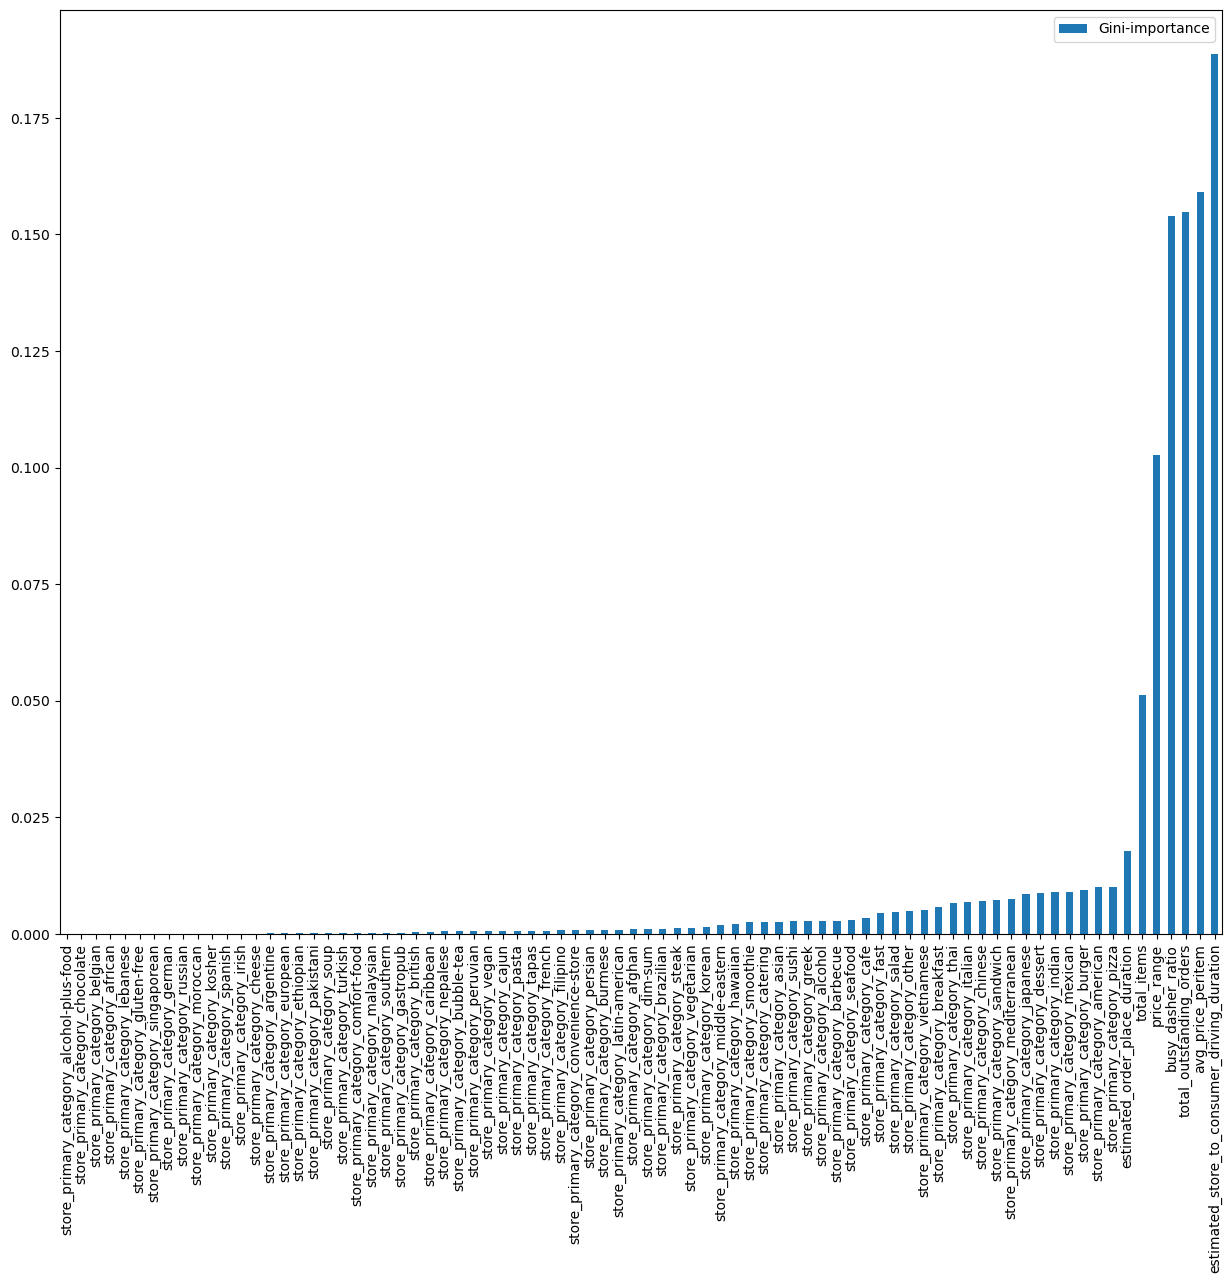

In [240]:
#get a bar plot of features with their importances

features=[f"feature {i}" for i in range((X.shape[1]))]
forest= RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feature_imp={} #dictionary holding feature with their corresponding importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feature_imp[feature]=importance
importances= pd.DataFrame.from_dict(feature_imp,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90,figsize=(15,12))
plt.show()


In [241]:
#obtaining the columns names in a list
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['store_primary_category_middle-eastern',
 'store_primary_category_hawaiian',
 'store_primary_category_smoothie',
 'store_primary_category_catering',
 'store_primary_category_asian',
 'store_primary_category_sushi',
 'store_primary_category_greek',
 'store_primary_category_alcohol',
 'store_primary_category_barbecue',
 'store_primary_category_seafood',
 'store_primary_category_cafe',
 'store_primary_category_fast',
 'store_primary_category_salad',
 'store_primary_category_other',
 'store_primary_category_vietnamese',
 'store_primary_category_breakfast',
 'store_primary_category_thai',
 'store_primary_category_italian',
 'store_primary_category_chinese',
 'store_primary_category_sandwich',
 'store_primary_category_mediterranean',
 'store_primary_category_japanese',
 'store_primary_category_dessert',
 'store_primary_category_indian',
 'store_primary_category_mexican',
 'store_primary_category_burger',
 'store_primary_category_american',
 'store_primary_category_pizza',
 'estimated_order_

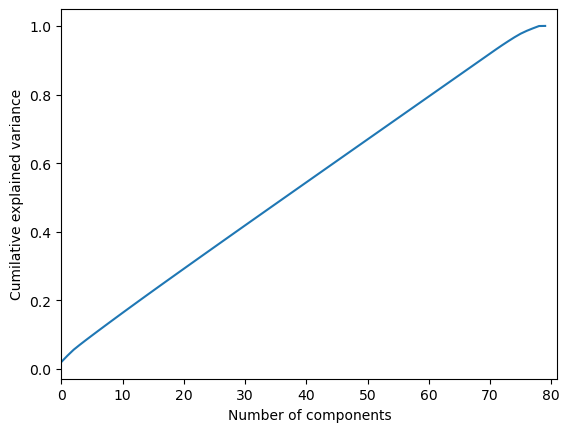

In [243]:
#performing Principal Component Analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_Train= X_train.values
X_Train= np.asarray(X_Train)

X_std= StandardScaler().fit_transform(X_Train)
pca= PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumilative explained variance')
plt.show()



In [247]:
#performing scaling to ensure optimization of the model
from sklearn.preprocessing import MinMaxScaler

def scale(scaler, X, y):
    X_scaler=scaler
    X_scaler.fit(X=X, y=y)
    X_scaled=X_scaler.transform(X)
    y_scaler=scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled= y_scaler.transform(y.values.reshape(-1,1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler
    

In [248]:
X_scaled, y_scaled, X_Scaler, y_scaler= scale(MinMaxScaler(),X,y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled= train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [254]:
from sklearn.metrics import mean_squared_error
def rmse_wath_anv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict= scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse = mean_squared_error(y_test,y_predict[:,0],squared=False)
    print("Error= "'{}'.format(rmse)+ "in" +model_name)
    return rmse, y_predict

In [ ]:
#running and training the model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), activation='logistic', max_iter=1000)
mlp.fit(X_train, y_train)
# Predict on the testing set
y_pred = mlp.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("RMSE:" mean_squared_error(y_test, y_pred, squared=False)")